# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import random
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')
df_all = [df_0, df_1, df_2]

for i in df_all:
    print(i.info())
    display(i.head())
    print('=============================================')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Удалим столбец id во всех таблицах, как не несущий полезной информации

In [3]:
for i in range(len(df_all)):
    df_all[i] = df_all[i].drop(['id'], axis=1)
    display(df_all[i].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


None

Визуализируем распределение значений целевого признака в разных регионах и рассчитаем их средние значения

92.50000000000001


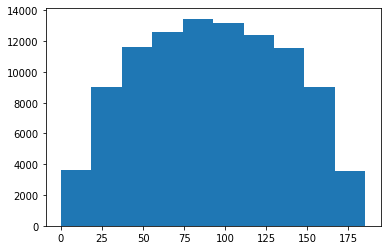

68.82500000000002


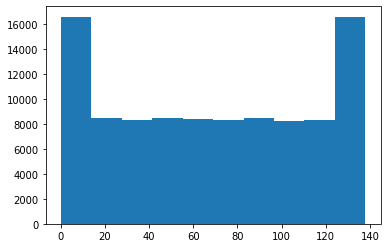

95.00000000000004


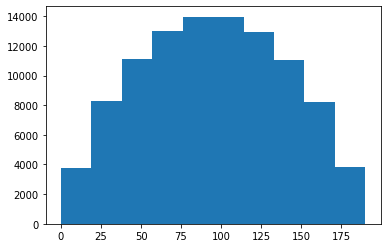

In [4]:
for i in range(len(df_all)):
    print(df_all[i]['product'].mean())
    plt.hist(df_all[i]['product'])
    plt.show()

## Обучение и проверка модели

Разобьем данные на обучающую и валидационную выборки в соотношении 75:25.

In [5]:
df_split=[[],[],[]] # создаем список списков для сохранения разбитых выборок для каждого региона
for split in range(len(df_all)):
    features = df_all[split].drop('product',axis=1) # создаем переменную с признаками для каждого региона
    target = df_all[split]['product']  # создаем переменную с  целевым признаком для каждого региона
    features_train, features_valid, target_train, target_valid = train_test_split( # разбиваем на выборки в соотношении 75:25
        features, target, test_size=0.25, random_state=12345)
    for item in [features_train, features_valid, target_train, target_valid]:
        df_split[split].append(item) # для каждого региона сохраняем 4 выборки
    print(f'Размеры выборок региона: {split}')
    for i in range(len(df_split[split])):
        print(df_split[split][i].shape) # проверим размерность получившихся выборок

Размеры выборок региона: 0
(75000, 3)
(25000, 3)
(75000,)
(25000,)
Размеры выборок региона: 1
(75000, 3)
(25000, 3)
(75000,)
(25000,)
Размеры выборок региона: 2
(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [6]:
models=[] # список для сохранения моделей для каждого региона
predictions=[] # список для сохранения предсказаний для каждого региона
for region in range(len(df_all)):
    models.append(LinearRegression())
    models[region].fit(df_split[region][0],df_split[region][2])  # обучаем модель на тренировочных выборках каждого региона
    predictions.append(models[region].predict(df_split[region][1])) # добавляем в список предсказания по каждому региону
    print(f'средний запас предсказанного сырья региона {region} равен: {predictions[region].mean().round(3)}')
    mse = mean_squared_error(df_split[region][3], predictions[region], squared=False) #
    print(f'RMSE: {(mse**0.5).round(3)}')

средний запас предсказанного сырья региона 0 равен: 92.593
RMSE: 6.13
средний запас предсказанного сырья региона 1 равен: 68.729
RMSE: 0.945
средний запас предсказанного сырья региона 2 равен: 94.965
RMSE: 6.327


RMSE минимальна у значений региона 1

## Подготовка к расчёту прибыли

Сохраним все ключевые значения в отдельных переменных

In [7]:
BUDGET = 10000 # млн.рублей
INCOME = .45 # Доход с каждой единицы продукта в млн.руб.
target = []
prediction = []
for region in range(len(df_all)):
    target.append(df_split[region][3].reset_index(drop=True))
    print(target[region].shape)
    prediction.append(pd.Series(predictions[region]))
    print(prediction[region].shape)

(25000,)
(25000,)
(25000,)
(25000,)
(25000,)
(25000,)


In [8]:
volume_lim = BUDGET/200/INCOME # достаточный объём сырья для безубыточной разработки новой скважины.
print(volume_lim)
for i in range(len(df_all)):
    print(f'Средние запасы в регионе {i} составляют {df_all[i]["product"].mean().round(3)} тыс.баррелей')

111.11111111111111
Средние запасы в регионе 0 составляют 92.5 тыс.баррелей
Средние запасы в регионе 1 составляют 68.825 тыс.баррелей
Средние запасы в регионе 2 составляют 95.0 тыс.баррелей


Рассчитанный объём сырья, необходимый  для безубыточной разработки новой скважины больше чем средние запасы сырья в каждом регионе.

Создадим функцию для расчета прибыли по выбранным скважинам и предсказаниям модели:

In [9]:
def revenue(target, probabilities, count):
    predict_sorted = probabilities.sort_values(ascending=False) #сортируем значения предсказаний по убыванию
    selected = target[predict_sorted.index][:count] #  определяем значения для отобранных скважин
    profit = selected.sum() * INCOME - BUDGET # прибыль в рублях с 200 скважин
    return profit

## Расчёт прибыли и рисков 

Чтобы найти распределение прибыли, применим технику Bootstrap с 1000 выборок.
Рассчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков

In [10]:
state = np.random.RandomState(12345)

def resultation(target, predict):
    profit_region=[] # список для сбора значений прибыли отобранных скважин
    for i in range(1000): 
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        pred_subsample = predict[target_subsample.index]  
        result = revenue(target_subsample, pred_subsample, 200) #обращаемся к функции расчета прибыли
        profit_region.append(result) 

    profit_region = pd.Series(profit_region)
    losses = (profit_region < 0).mean()*100 # считаем процентное отношение количества отрицательных значений прибыли
    profit_region_mean = profit_region.mean()
    lower = profit_region.quantile(0.025) 
    upper = profit_region.quantile(0.975)
    print(f'Средняя прогнозная прибыль равна {(profit_region_mean).round(3)} млрд.рублей')
    print(f'Возможная прибыль: от {(lower).round(3)} до {(upper).round(3)} млрд.рублей')
    print(f'Риск убытков составляет {losses} %')

for region in range(len(df_all)):
    print(f'Расчет прибыли и рисков для региона {region}:')
    resultation(target[region],prediction[region])
    print() 

Расчет прибыли и рисков для региона 0:
Средняя прогнозная прибыль равна 425.939 млрд.рублей
Возможная прибыль: от -102.09 до 947.976 млрд.рублей
Риск убытков составляет 6.0 %

Расчет прибыли и рисков для региона 1:
Средняя прогнозная прибыль равна 518.259 млрд.рублей
Возможная прибыль: от 128.123 до 953.613 млрд.рублей
Риск убытков составляет 0.3 %

Расчет прибыли и рисков для региона 2:
Средняя прогнозная прибыль равна 420.194 млрд.рублей
Возможная прибыль: от -115.853 до 989.63 млрд.рублей
Риск убытков составляет 6.2 %



Очевидно, что, исходя из полученных данных: минимальных рисков убытков(0,3%) и максимальной средней средней прибыли(518 млрд.руб.) наилучший регион для разработки - это регион 1
    

### Общий вывод

В ходе исследования была обработана информация геологоразведки трёх регионов. 

Для каждого региона была построена модель для предсказания объёма запасов в новых скважинах и определена прибыль, которую должна принести добыча нефти. Для каждого региона были отобраны скважины с самыми высокими оценками значений. В результате проведенного исследования определено, что наилучший регион для разработки - это регион 1, поскольку по сравнению с другими регионами добыча нефти в нем сопряжена с минимальными рисков от убытков(0,3%), при том что есть возможность получить максимальную среднюю прибыль(518 млрд.руб.).